In [4]:
import pandas as pd
import mysql.connector
import os

# Folder containing your CSV files
folder_path = r"/Users/syedmdriaz/Downloads/Target_E-commerce"

# Automatically detect CSV files and derive table names
csv_files = []
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        table_name = os.path.splitext(filename)[0].lower().replace('-', '_').replace(' ', '_')
        csv_files.append((filename, table_name))

# MySQL connection setup
try:
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='MySQL9.2.0',
        database='Target_Ecommerce'
    )
    cursor = conn.cursor()
    print("✅ Connected to MySQL.")
except Exception as e:
    print(f"❌ Could not connect to MySQL: {e}")
    raise

# Function to convert pandas dtype to SQL
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# Process each CSV
for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f"❌ Failed to read {csv_file}: {e}")
        continue

    df = df.where(pd.notnull(df), None)
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    print(f"📄 Processing {csv_file} with {len(df)} rows.")

    try:
        # Create table
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        cursor.execute(create_table_query)

        # Insert rows
        for _, row in df.iterrows():
            values = tuple(None if pd.isna(x) else x for x in row)
            sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
            cursor.execute(sql, values)

        conn.commit()
        print(f"✅ Successfully imported `{csv_file}` into `{table_name}`")

    except Exception as e:
        print(f"❌ Failed to insert `{csv_file}`: {e}")

# Cleanup
cursor.close()
conn.close()
print("🔒 MySQL connection closed.")

✅ Connected to MySQL.
📄 Processing customers.csv with 99441 rows.
✅ Successfully imported `customers.csv` into `customers`
📄 Processing products.csv with 32951 rows.
✅ Successfully imported `products.csv` into `products`
📄 Processing orders.csv with 99441 rows.
✅ Successfully imported `orders.csv` into `orders`
📄 Processing geolocation.csv with 1000163 rows.
✅ Successfully imported `geolocation.csv` into `geolocation`
📄 Processing payments.csv with 103886 rows.
✅ Successfully imported `payments.csv` into `payments`
📄 Processing sellers.csv with 3095 rows.
✅ Successfully imported `sellers.csv` into `sellers`
📄 Processing order_items.csv with 112650 rows.
✅ Successfully imported `order_items.csv` into `order_items`
🔒 MySQL connection closed.


In [1]:
!pip install matplotlib

In [2]:
!pip install seaborn


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "MySQL9.2.0",
                            database = "Target_Ecommerce")

cur = db.cursor()

# 1. List all unique cities where customers are located. 

In [13]:
query = """select distinct customer_city from customers"""
cur.execute (query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head(10)
#data(it will show all the unique citys in that data)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# 2. Count the number of orders placed in 2017.


In [16]:
query = """select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 225505)

# 3. Find the total sales per category.

In [23]:
query = """select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products
join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","sales"])
top_n = 10  # Top N categories
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


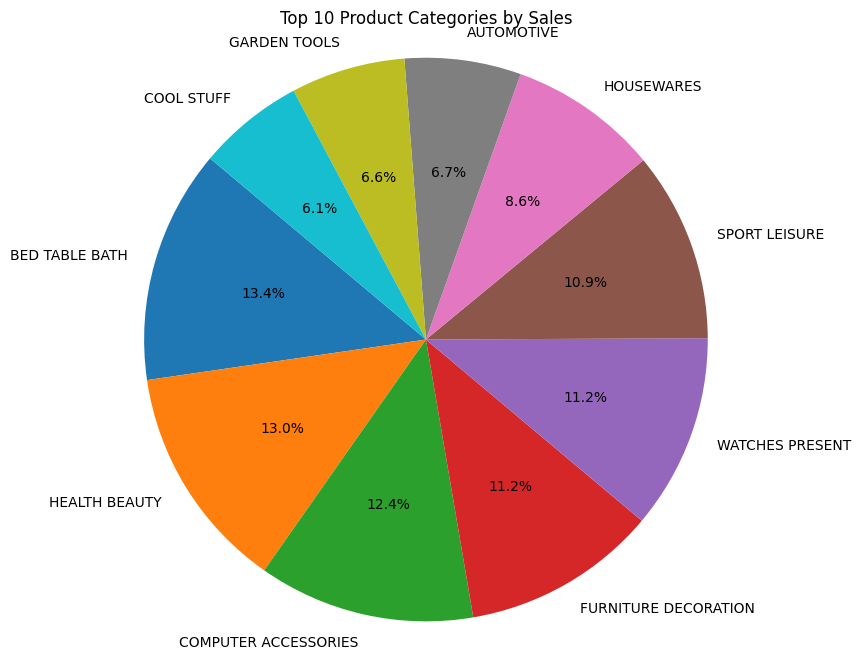

In [25]:
import matplotlib.pyplot as plt

# Sort the dataframe by sales (descending)
df_sorted = df.sort_values(by='sales', ascending=False)

# Pick top N categories
top_n = 10
df_top = df_sorted.head(top_n)

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(df_top['sales'], labels=df_top['category'], autopct='%1.1f%%', startangle=140)
plt.title(f'Top {top_n} Product Categories by Sales')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

# 4. Calculate the percentage of orders that were paid in installments.

In [19]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]





('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# 5. Count the number of customers from each state. 

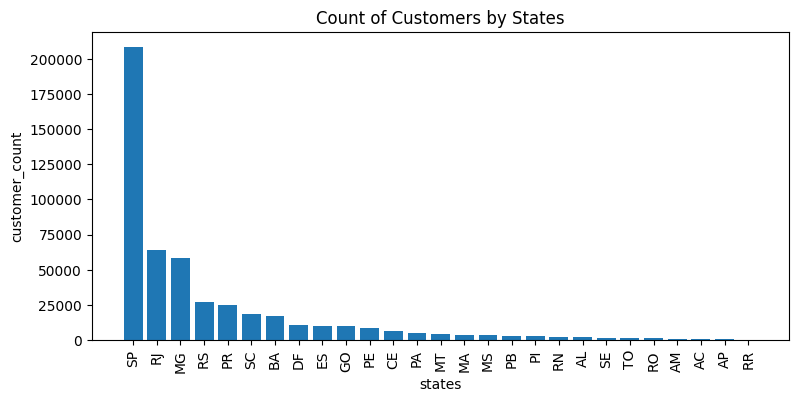

In [34]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (9,4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# 6. Calculate the number of orders per month in 2018.

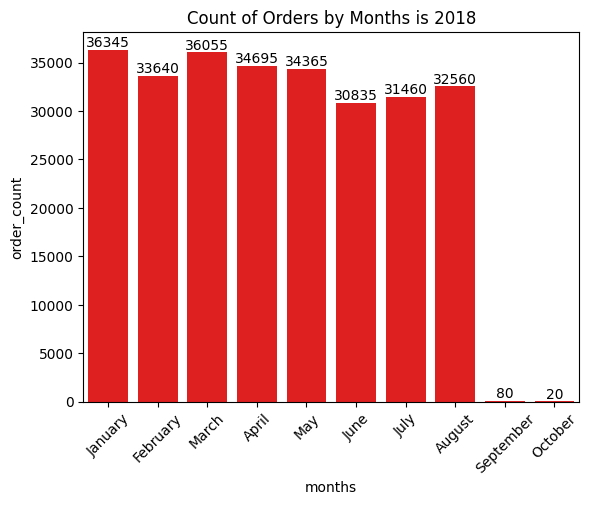

In [37]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count from
orders where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(query) # Executes the SQL query.

data = cur.fetchall() # Fetches all the results from the executed query.

df = pd.DataFrame(data, columns = ["months", "order_count"]) # Creates a Pandas DataFrame from the fetched data, assigning column names "months" and "order_count".

o = ["January", "February","March","April","May","June","July","August","September","October"] # Defines a list of months in chronological order, presumably for ordering the x-axis of the bar plot.

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red") # Creates a bar plot using Seaborn, with "months" on the x-axis, "order_count" on the y-axis, using the specified order for months, and setting the bar color to red.

plt.xticks(rotation = 45) # Rotates the x-axis labels by 45 degrees for better readability.

ax.bar_label(ax.containers[0]) # Adds labels to each bar in the bar plot, displaying the corresponding "order_count" value.

plt.title("Count of Orders by Months is 2018") # Sets the title of the plot.

plt.show() # Displays the plot.

# 7. Find the average number of products per order, grouped by customer city.

In [47]:
query = """WITH Count_per_order as (select orders.order_id,orders.customer_id,count(order_items.order_id) as Order_Count
	from orders 
	join order_items
	on orders.order_id = order_items.order_id
	group by orders.order_id,orders.customer_id
)
select customers.customer_city,avg(Count_per_order.Order_Count)
FROM customers 
join Count_per_order 
on customers.customer_id = Count_per_order.customer_id
group by customers.customer_city"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,treze tilias,6.3636
1,indaial,5.5769
2,sao jose dos campos,5.6924
3,sao paulo,5.7811
4,porto alegre,5.8746
5,santos,5.8074
6,sao francisco do sul,6.1765
7,sao vicente,5.4545
8,joinville,5.5133
9,sao vendelino,5.0000


/var/folders/dq/d38zpnmx2t548tkg9pc5kg8m0000gn/T/ipykernel_3074/1300517047.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average products/order', y='customer city', data=df_top10, palette='coolwarm')


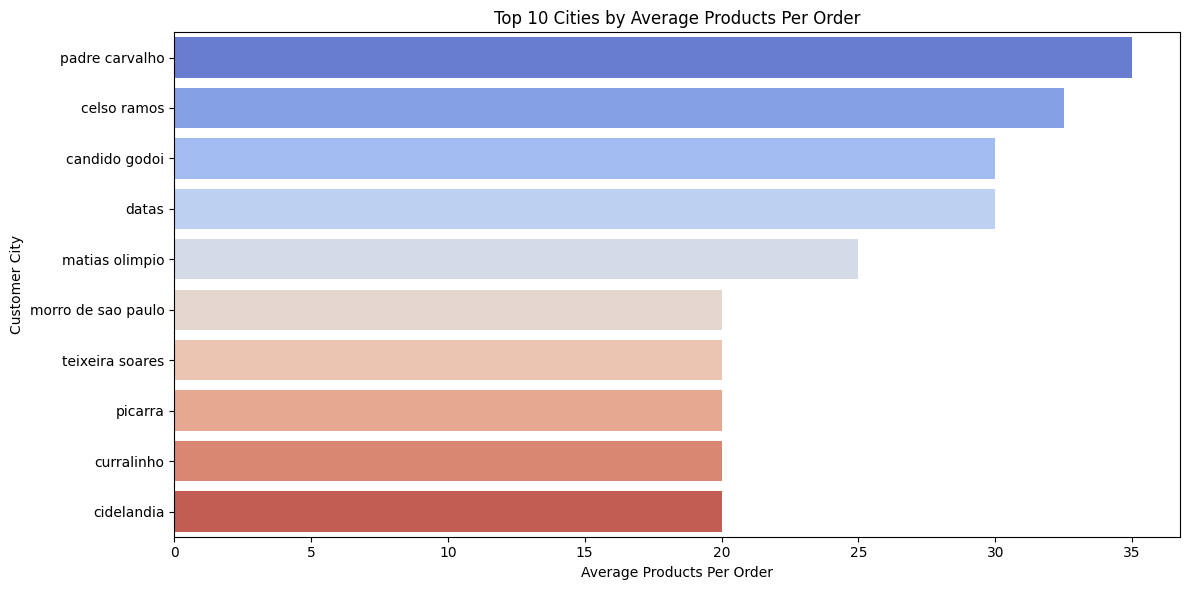

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort and select top 10
df_top10 = df.sort_values(by='average products/order', ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='average products/order', y='customer city', data=df_top10, palette='coolwarm')
plt.title('Top 10 Cities by Average Products Per Order')
plt.xlabel('Average Products Per Order')
plt.ylabel('Customer City')
plt.tight_layout()
plt.show()

# 8. Calculate the percentage of total revenue contributed by each product category.

In [49]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# 9. Identify the correlation between product price and the number of times a product has been purchased.

In [56]:
import numpy as np
query = """
SELECT 
    p.product_category, 
    COUNT(oi.product_id),
    ROUND(AVG(oi.price), 2)
FROM products p
JOIN order_items oi ON p.product_id = oi.product_id
GROUP BY p.product_category;
"""

cursor = db.cursor()
cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=["Category", "order_count", "price"])

correlation = np.corrcoef(df["order_count"], df["price"])[0, 1]
print("The correlation is", correlation)


The correlation is -0.10631514167157567


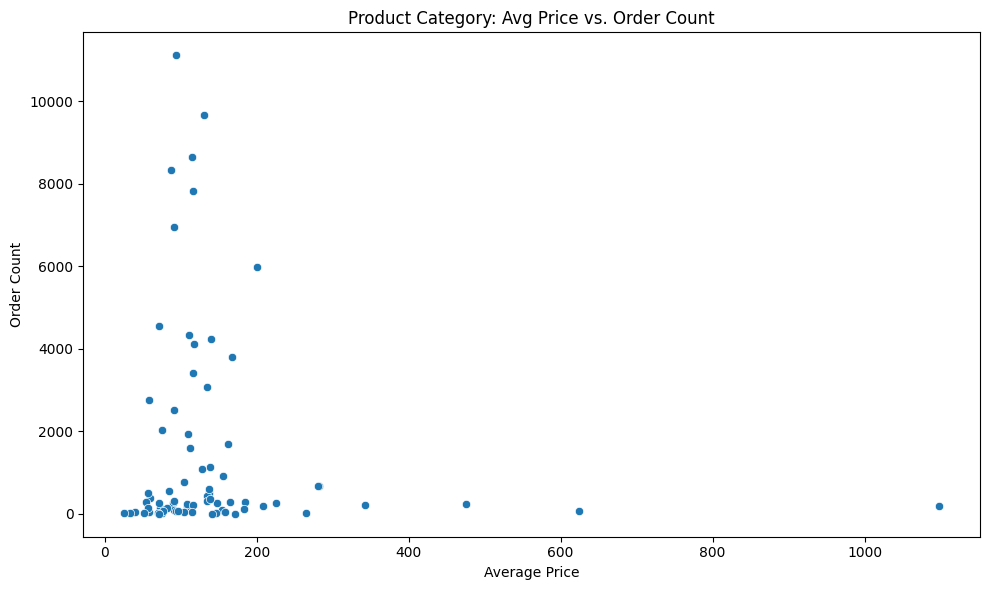

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="price", y="order_count")
plt.title("Product Category: Avg Price vs. Order Count")
plt.xlabel("Average Price")
plt.ylabel("Order Count")
plt.tight_layout()
plt.show()

# 10. Calculate the total revenue generated by each seller, and rank them by revenue.

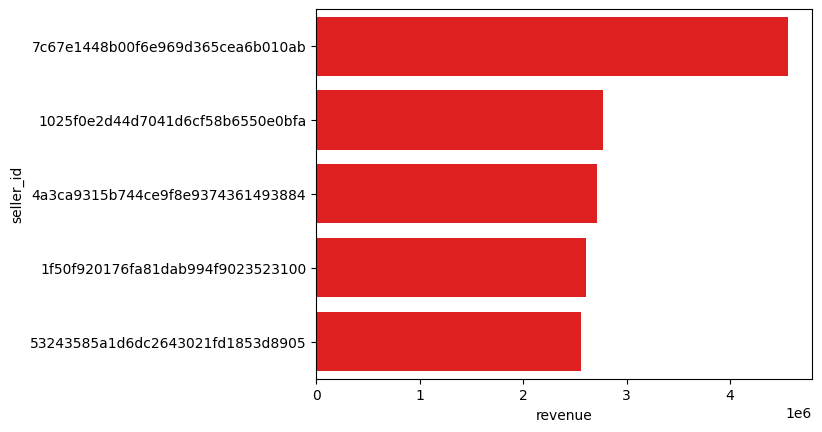

In [17]:

query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "revenue", y = "seller_id", data = df, color = "red")
plt.xticks(rotation = 0)
plt.show()

# 11. Calculate the moving average of order values for each customer over their order history

In [11]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cursor = db.cursor()
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df


,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2181601,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2181602,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2181603,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2181604,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 12 Calculate the cumulative sales per month for each year.

In [7]:
query = """select years, months, payment, 
sum(payment) over(order by years, months) as cumulative_sales 
from (
	select year(orders.order_purchase_timestamp) as years,
		   month(orders.order_purchase_timestamp) as months,
		   round(sum(payments.payment_value),2) as payment
	from orders 
	join payments on orders.order_id = payments.order_id
	group by years, months
	order by years, months
) as subquery """
cursor = db.cursor()
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,8071.68,8.071680e+03
1,2016,10,1890895.36,1.898967e+06
2,2016,12,627.84,1.899595e+06
3,2017,1,4431617.28,6.331212e+06
4,2017,2,9341056.30,1.567227e+07
5,2017,3,14395635.18,3.006790e+07
6,2017,4,13369216.94,4.343712e+07
7,2017,5,18973402.24,6.241052e+07
8,2017,6,16360844.17,7.877137e+07
9,2017,7,18956253.42,9.772762e+07


# 13. Calculate the year-over-year growth rate of total sales.

In [6]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cursor = db.cursor()
cursor.execute(query)
data = cursor.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

# 15. Calculate the total revenue generated by each seller, and rank them by revenue.

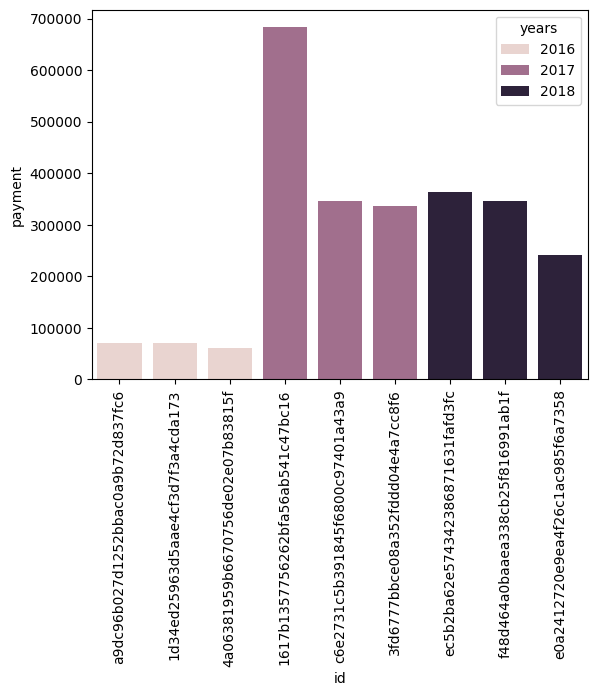

In [12]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()